In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    TunedThresholdClassifierCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, make_scorer, classification_report
)

import optuna

sns.set_theme(context='notebook', style='ticks')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [56]:
df = pd.read_csv('../data/processed/pulsar_processed.csv')
df.head()

,PC1,PC2,PC3,PC4,PC5,target_class
0,-1.278849,1.273133,0.016213,0.662102,0.577362,0
1,-1.020553,0.201162,0.670478,1.605779,-0.390326,0
2,0.188289,-0.432114,-0.979766,-0.519232,-0.305346,0
3,-1.015466,1.469881,-0.018832,0.938386,0.495189,0
4,-0.822626,-2.123651,0.407953,-0.380922,-0.654083,0


In [57]:
X = df.drop(columns=['target_class'])
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')

Training samples: 14318
Test samples: 3580


Here we first train a logistic regression model with hyperparameter optimization using Optuna to maximize the cross-validated F1 score. Then, we use `TunedThresholdClassifierCV` to find the optimal decision threshold based on F1 score through cross-validation.

In [58]:
def objective(trial):
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2']) if solver == 'liblinear' else 'l2'
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
    )
    cv_hp = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv_hp, scoring='f1')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=False)

best_params = study.best_trial.params.copy()
best_solver = best_params['solver']
best_penalty = best_params.get('penalty', 'l2')
best_C = best_params['C']

print(f"Best cross-validated F1 (HP): {study.best_value:.4f}")
print('Best hyperparameters:', {'solver': best_solver, 'penalty': best_penalty, 'C': best_C})

Best cross-validated F1 (HP): 0.8282
Best hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 206.64559624362437}


In [59]:
base = LogisticRegression(
    C=best_C,
    penalty=best_penalty,
    solver=best_solver,
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
)

The best classification threshold we found is 0.8485. This means that we classify a sample as positive only if the predicted probability is >= to 0.8485.

In [60]:
scorer = make_scorer(f1_score, pos_label=1)
cv_thr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = TunedThresholdClassifierCV(
    estimator=base,
    scoring=scorer,
    cv=cv_thr,
    thresholds=100,
    response_method="auto",
    refit=True
)

clf.fit(X_train, y_train)
print(f"Best threshold (CV): {clf.best_threshold_:.4f}")

Best threshold (CV): 0.8485


Now we evaluate the model on the test set using both the best hyperparameters and the best decision threshold found through cross-validation. The classification report shows good performance with a precision of 92.03%, recall of 84.45% and F1-score of 88.08%.

In [61]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=3))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall   :", recall_score(y_test, y_test_pred))
print("F1       :", f1_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0      0.984     0.993     0.989      3252
           1      0.920     0.845     0.881       328

    accuracy                          0.979      3580
   macro avg      0.952     0.919     0.935      3580
weighted avg      0.979     0.979     0.979      3580

Precision: 0.920265780730897
Recall   : 0.8445121951219512
F1       : 0.8807631160572337


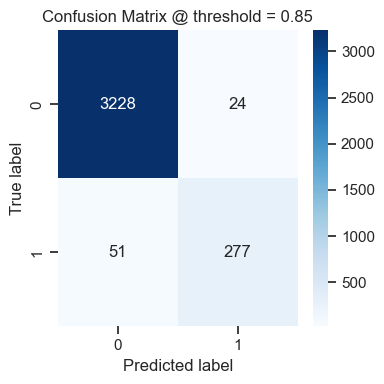

In [62]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title(f'Confusion Matrix @ threshold = {clf.best_threshold_:.2f}')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

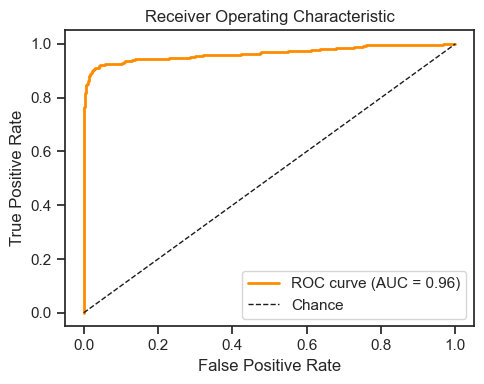

In [63]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {default_metrics['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()